In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms.functional as F
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

Files already downloaded and verified
Files already downloaded and verified
Number of classes in dataset: 10
Unique labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
4


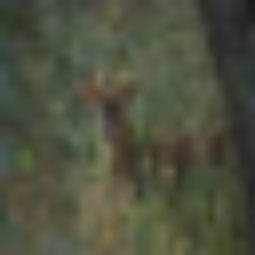

In [46]:

train_data = CIFAR10(root='cifar10_data/', train=True, download=True,) 
test_data = CIFAR10(root='cifar10_data/', train=False, download=True) 

print('Number of classes in dataset:', len(train_data.classes))
print('Unique labels:', train_data.classes)

demo_img, demo_label = train_data[10]

print(demo_label)
torchvision.transforms.functional.resize(demo_img, (255, 255))

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = CIFAR10(root='cifar10_data/', train=True, download=True, transform=transform)
test_data = CIFAR10(root='cifar10_data/', train=False, download=True, transform=transform) 
# Define the size of the subset as a fraction of the original dataset
subset_fraction = 0.2 ## You can play with this to get a bigger or smaller subset

# Create indices for the training subset
train_indices = np.random.choice(len(train_data), int(len(train_data) * subset_fraction), replace=False)

# Create the training subset
train_subset = Subset(train_data, train_indices)

# For the test set, you can do the same or use the full test set
test_indices = np.random.choice(len(test_data), int(len(test_data) * subset_fraction), replace=False)
test_subset = Subset(test_data, test_indices)

# Check the size of the subset
print(f"Training subset size: {len(train_subset)}")
print(f"Test subset size: {len(test_subset)}")

# Define the DataLoaders
train_loader = DataLoader(train_subset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=10, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Training subset size: 10000
Test subset size: 2000


In [68]:

num_epochs = 30
lr = 1e-4

device = 'cuda' if torch.cuda.is_available() else 'cpu'  # checks if machine supports cuda and if it does, we use that, otherwise cpu
train_losses = []
val_losses = []

model = nn.Sequential(
    # nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=0),
    # nn.Tanh(),
    # # output size = (in - kernal_size + 2*padding) / stride + 1
    # #output size = 32-5+1 = 28
    # nn.MaxPool2d(kernel_size=2, stride=2),
    # #output size = 28/2 = 14
    # nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0),
    # nn.Tanh(),
    #output size = 14-5+1 = 10

    nn.Flatten(), 
    nn.Linear(32*32*3, 1045),
    nn.Tanh(),
    nn.Linear(1045, 128),
    nn.Tanh(),
    nn.Linear(128, 10),  
    nn.LogSoftmax(dim=1) 
)

model.to(device)  # we need to send all input tensors as well as our model to this device. by default they are on cpu

print(f'Using device {device}')


optimizer = optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()  # multi-class


Using device cuda


In [69]:

for epoch_no in range(num_epochs):

  model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

  epoch_weighted_loss = 0

  for batch_X, batch_y in train_loader:

    batch_X = batch_X.to(device)  # convert to [N, 28*28] shape where N is batch_size
    batch_y = batch_y.to(device)

    batch_y_probs = model(batch_X)  # outputs [N, 10] where each [:, 10] is probabilities for class (0-9)

    loss = criterion(batch_y_probs, batch_y)

    optimizer.zero_grad()  # need to clear out gradients from previous batch
    loss.backward()  # calculate new gradients
    optimizer.step()  # update weights

    epoch_weighted_loss += (len(batch_y)*loss.item())

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(epoch_loss)    # add loss for tracking. we'll visualize the loss trajectory later


  # validation time

  model.eval()  # take model to evaluation mode. turn off train-only layers
  correctly_labelled = 0

  with torch.no_grad():  # this makes our model to NOT track gradients

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in test_loader:

      val_batch_X = val_batch_X.to(device)
      val_batch_y = val_batch_y.to(device)

      val_batch_y_probs = model(val_batch_X)

      loss = criterion(val_batch_y_probs, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob

      correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

  val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss:.3f}, val_loss={val_epoch_loss:.3f}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}. Change device variable and run again to see the difference.')

Epoch: 0, train_loss=1.874, val_loss=1.803. labelled 718/2000 correctly (35.9% accuracy)
Epoch: 1, train_loss=1.689, val_loss=1.738. labelled 798/2000 correctly (39.900000000000006% accuracy)
Epoch: 2, train_loss=1.575, val_loss=1.701. labelled 818/2000 correctly (40.9% accuracy)
Epoch: 3, train_loss=1.455, val_loss=1.689. labelled 839/2000 correctly (41.949999999999996% accuracy)
Epoch: 4, train_loss=1.334, val_loss=1.676. labelled 860/2000 correctly (43.0% accuracy)
Epoch: 5, train_loss=1.205, val_loss=1.712. labelled 830/2000 correctly (41.5% accuracy)
